# Models and Evaluation

In [66]:
import pandas as pd
import numpy as np
from IPython.display import display

data = pd.read_csv('data_processed/data.csv')

display(data.head())

,loan_id,account_id,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,...,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,age_on_loan_request,age_on_loan_request_disc
0,5314,1787,96396,12,8033,-1,30,weekly issuance,2166,2166,...,13,10,10,0.818,9650,0.100,0.29,-0.001909,46,40-49
1,5316,1801,165960,36,4610,1,46,monthly issuance,2181,2181,...,20,10,10,0.735,8369,0.117,0.52,-0.002094,25,21-29
2,6863,9188,127080,60,2118,1,45,monthly issuance,11006,11314,...,19,7,5,0.535,8390,0.132,0.61,0.000539,57,50-59
3,5325,1843,105804,36,2939,1,12,monthly issuance,2235,2235,...,27,11,9,0.748,10045,0.135,0.29,-0.001739,53,50-59
4,7240,11013,274740,60,4579,1,1,weekly issuance,13231,13539,...,36,6,5,0.505,8288,0.110,0.73,-0.001179,15,0-19


### Remove unnecessary features (Ids)

In [67]:
no_ids = [c for c in data.columns if c[-3:] != '_id' and c != 'code']
data = data[no_ids]
# data.drop(['account_frequency', 'gender', 'card_type'], axis=1, inplace=True)

display(data.head())
display(data.info())

,loan_amount,loan_duration,loan_payments,status,account_frequency,has_disponent,gender,last_balance,monthly_diff,region,...,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,age_on_loan_request,age_on_loan_request_disc
0,96396,12,8033,-1,weekly issuance,False,Female,20100.0,6700,west Bohemia,...,13,10,10,0.818,9650,0.100,0.29,-0.001909,46,40-49
1,165960,36,4610,1,monthly issuance,False,Male,52208.9,14733,east Bohemia,...,20,10,10,0.735,8369,0.117,0.52,-0.002094,25,21-29
2,127080,60,2118,1,monthly issuance,False,Male,20272.8,-6859,east Bohemia,...,19,7,5,0.535,8390,0.132,0.61,0.000539,57,50-59
3,105804,36,2939,1,monthly issuance,False,Female,34292.7,-11054,south Bohemia,...,27,11,9,0.748,10045,0.135,0.29,-0.001739,53,50-59
4,274740,60,4579,1,weekly issuance,False,Male,41142.9,-30531,south Moravia,...,36,6,5,0.505,8288,0.110,0.73,-0.001179,15,0-19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   loan_amount                                      328 non-null    int64  
 1   loan_duration                                    328 non-null    int64  
 2   loan_payments                                    328 non-null    int64  
 3   status                                           328 non-null    int64  
 4   account_frequency                                328 non-null    object 
 5   has_disponent                                    328 non-null    bool   
 6   gender                                           328 non-null    object 
 7   last_balance                                     328 non-null    float64
 8   monthly_diff                                     328 non-null    int64  
 9   region                          

None

In [68]:
def get_features(df):
    return df.drop('status', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['status']), axis=1)

results = {}

### Encode

In [69]:
def encode_data(df, columns):
    from sklearn.preprocessing import OrdinalEncoder
    le = OrdinalEncoder()
    cols = [col for col in columns if col in df.keys()]
    df[cols] = le.set_params(encoded_missing_value=-1).fit_transform(df[cols])
    return df

In [70]:
categorical_columns = list(data.select_dtypes("object").columns)
data = encode_data(data, categorical_columns)

data

,loan_amount,loan_duration,loan_payments,status,account_frequency,has_disponent,gender,last_balance,monthly_diff,region,...,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,age_on_loan_request,age_on_loan_request_disc
0,96396,12,8033,-1,2.0,False,0.0,20100.0,6700,7.0,...,13,10,10,0.818,9650,0.100,0.29,-0.001909,46,3.0
1,165960,36,4610,1,1.0,False,1.0,52208.9,14733,2.0,...,20,10,10,0.735,8369,0.117,0.52,-0.002094,25,1.0
2,127080,60,2118,1,1.0,False,1.0,20272.8,-6859,2.0,...,19,7,5,0.535,8390,0.132,0.61,0.000539,57,4.0
3,105804,36,2939,1,1.0,False,0.0,34292.7,-11054,5.0,...,27,11,9,0.748,10045,0.135,0.29,-0.001739,53,4.0
4,274740,60,4579,1,2.0,False,1.0,41142.9,-30531,6.0,...,36,6,5,0.505,8288,0.110,0.73,-0.001179,15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,155616,48,3242,1,1.0,True,0.0,60694.1,5313,4.0,...,50,11,4,0.626,8994,0.110,0.99,-0.002052,26,1.0
324,222180,60,3703,-1,1.0,False,1.0,59578.8,4583,7.0,...,10,6,6,0.556,8843,0.113,0.78,0.001531,58,4.0
325,45024,48,938,1,1.0,False,0.0,38384.3,8387,4.0,...,2,13,7,0.899,10177,0.081,1.12,0.000806,40,3.0
326,115812,36,3217,1,1.0,False,1.0,41878.1,2204,5.0,...,21,11,8,0.569,8427,0.107,0.42,0.000415,44,3.0


## Feature Selection
### Wrapper Method
Split Data into subsets and train a model using this. Based on the output of the model, add or subtract features and train the model again.
#### 1. Forward Selection

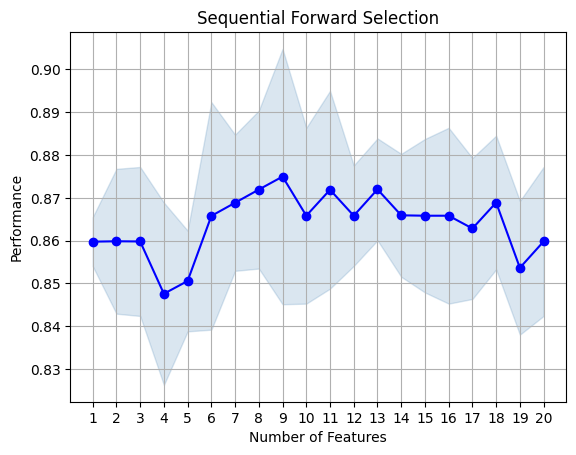

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[0.8484848484848485, 0.8636363636363636, 0.863...",0.859767,"(loan_duration,)",0.00735,0.005719,0.002859
2,"(1, 12)","[0.8333333333333334, 0.8636363636363636, 0.848...",0.85986,"(loan_duration, no. of cities )",0.021733,0.016909,0.008455
3,"(1, 4, 12)","[0.8484848484848485, 0.8636363636363636, 0.848...",0.859814,"(loan_duration, has_disponent, no. of cities )",0.022364,0.0174,0.0087
4,"(1, 4, 10, 12)","[0.8181818181818182, 0.8636363636363636, 0.848...",0.847599,"(loan_duration, has_disponent, no. of municipa...",0.027365,0.021291,0.010645
5,"(1, 2, 4, 10, 12)","[0.8484848484848485, 0.8484848484848485, 0.863...",0.850583,"(loan_duration, loan_payments, has_disponent, ...",0.015118,0.011763,0.005881
6,"(1, 2, 4, 6, 10, 12)","[0.8636363636363636, 0.9090909090909091, 0.848...",0.865781,"(loan_duration, loan_payments, has_disponent, ...",0.034148,0.026569,0.013284
7,"(1, 2, 4, 6, 7, 10, 12)","[0.8636363636363636, 0.8939393939393939, 0.863...",0.868858,"(loan_duration, loan_payments, has_disponent, ...",0.020437,0.015901,0.00795
8,"(1, 2, 3, 4, 6, 7, 10, 12)","[0.8636363636363636, 0.8939393939393939, 0.863...",0.871935,"(loan_duration, loan_payments, account_frequen...",0.023711,0.018448,0.009224
9,"(1, 2, 3, 4, 6, 7, 8, 10, 12)","[0.8636363636363636, 0.9090909090909091, 0.863...",0.874965,"(loan_duration, loan_payments, account_frequen...",0.038325,0.029818,0.014909
10,"(1, 2, 3, 4, 6, 7, 8, 10, 12, 14)","[0.8636363636363636, 0.8787878787878788, 0.863...",0.865828,"(loan_duration, loan_payments, account_frequen...",0.02639,0.020532,0.010266


In [120]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


originalFeatures = get_features(data)
x = originalFeatures
y = data['status']

def forward_selection(featuresData, target, k_features = 20):
    sfs = SFS(RandomForestClassifier(),
              k_features=k_features,
              forward=True,
              floating=False,
              cv = 5,
              scoring = 'accuracy',
              n_jobs = -1)
    sfs = sfs.fit(x, y)
    fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
    plt.title('Sequential Forward Selection')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sfs.get_metric_dict()).T

forward_selection_result = forward_selection(x, y)
forward_selection_result

#### 2. Backward Elimination

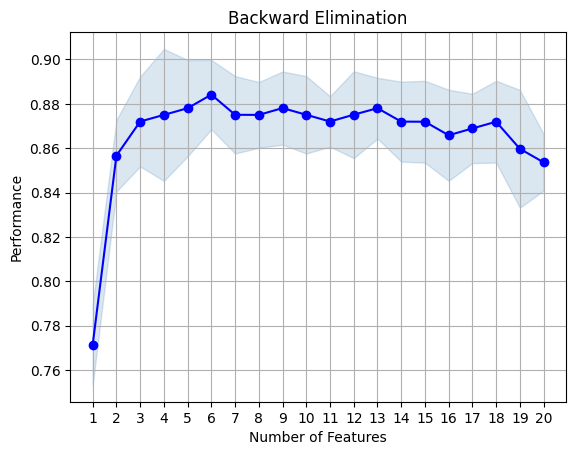

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
20,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8484848484848485, 0.8636363636363636, 0.863...",0.853613,"(loan_amount, loan_duration, loan_payments, ac...",0.016378,0.012743,0.006371
19,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8484848484848485, 0.8787878787878788, 0.863...",0.85972,"(loan_amount, loan_duration, loan_payments, ac...",0.034164,0.026581,0.01329
18,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8636363636363636, 0.8939393939393939, 0.863...",0.871935,"(loan_amount, loan_duration, loan_payments, ha...",0.023711,0.018448,0.009224
17,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...","[0.8636363636363636, 0.8787878787878788, 0.863...",0.868904,"(loan_amount, loan_duration, loan_payments, ha...",0.020064,0.015611,0.007805
16,"(0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 1...","[0.8636363636363636, 0.8787878787878788, 0.863...",0.865828,"(loan_amount, loan_duration, loan_payments, ha...",0.02639,0.020532,0.010266
15,"(0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 1...","[0.8636363636363636, 0.8939393939393939, 0.863...",0.871935,"(loan_amount, loan_duration, loan_payments, ha...",0.023711,0.018448,0.009224
14,"(0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16)","[0.8484848484848485, 0.8939393939393939, 0.863...",0.871981,"(loan_amount, loan_duration, loan_payments, ha...",0.023179,0.018034,0.009017
13,"(0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 13, 15, 16)","[0.8787878787878788, 0.8939393939393939, 0.863...",0.878042,"(loan_amount, loan_duration, loan_payments, ha...",0.017592,0.013687,0.006844
12,"(0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 15, 16)","[0.8484848484848485, 0.8787878787878788, 0.863...",0.875105,"(loan_amount, loan_duration, has_disponent, ge...",0.02518,0.019591,0.009795
11,"(0, 1, 4, 5, 6, 7, 9, 10, 13, 15, 16)","[0.8636363636363636, 0.8636363636363636, 0.863...",0.872028,"(loan_amount, loan_duration, has_disponent, ge...",0.014615,0.011371,0.005685


In [122]:
def backward_selection(featuresData, target, k_features = 1):
    sbs = SFS(RandomForestClassifier(),
              k_features=1,
              forward=False,
              floating=False,
              scoring = 'accuracy',
              cv = 5,
              n_jobs = -1)
    sbs = sbs.fit(x, y)
    fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
    plt.title('Backward Elimination')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sbs.get_metric_dict()).T

backward_selection_result = backward_selection(x, y)
backward_selection_result

#### Bi-directional Elimination (Step-wise Selection)

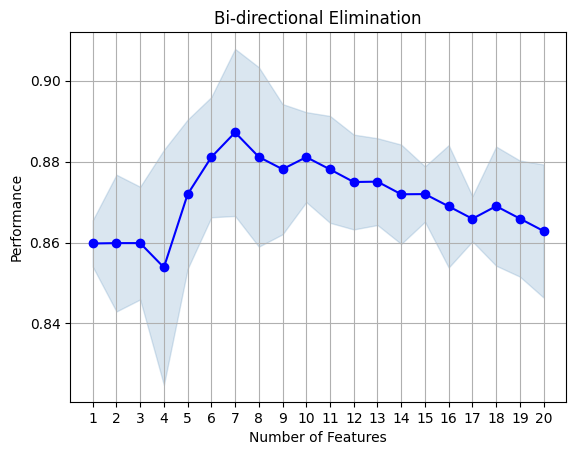

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[0.8484848484848485, 0.8636363636363636, 0.863...",0.859767,"(loan_duration,)",0.00735,0.005719,0.002859
2,"(1, 12)","[0.8333333333333334, 0.8636363636363636, 0.848...",0.85986,"(loan_duration, no. of cities )",0.021733,0.016909,0.008455
3,"(1, 4, 12)","[0.8484848484848485, 0.8484848484848485, 0.848...",0.85986,"(loan_duration, has_disponent, no. of cities )",0.017906,0.013932,0.006966
4,"(1, 4, 7, 12)","[0.8333333333333334, 0.8333333333333334, 0.833...",0.853846,"(loan_duration, has_disponent, monthly_diff, n...",0.037344,0.029055,0.014527
5,"(1, 4, 7, 11, 15)","[0.8636363636363636, 0.8939393939393939, 0.863...",0.871935,"(loan_duration, has_disponent, monthly_diff, n...",0.023711,0.018448,0.009224
6,"(0, 4, 5, 6, 7, 15)","[0.8787878787878788, 0.8787878787878788, 0.878...",0.881119,"(loan_amount, has_disponent, gender, last_bala...",0.019114,0.014872,0.007436
7,"(0, 1, 4, 6, 7, 8, 15)","[0.8787878787878788, 0.8939393939393939, 0.878...",0.887226,"(loan_amount, loan_duration, has_disponent, la...",0.026544,0.020652,0.010326
8,"(0, 1, 3, 4, 6, 7, 8, 15)","[0.8787878787878788, 0.8787878787878788, 0.863...",0.881166,"(loan_amount, loan_duration, account_frequency...",0.028511,0.022183,0.011091
9,"(0, 1, 3, 4, 5, 6, 8, 11, 15)","[0.8636363636363636, 0.8787878787878788, 0.863...",0.878135,"(loan_amount, loan_duration, account_frequency...",0.020692,0.016099,0.00805
10,"(0, 1, 4, 5, 6, 7, 8, 9, 11, 15)","[0.8787878787878788, 0.8939393939393939, 0.863...",0.881119,"(loan_amount, loan_duration, has_disponent, ge...",0.014292,0.01112,0.00556


In [123]:
def bi_directional_elimination(featuresData, target, k_features = 1):
    sffs = SFS(RandomForestClassifier(),
              k_features=(1,20),
              forward=True,
              floating=True,
              scoring = 'accuracy',
              cv = 5,
              n_jobs = -1)
    sffs = sffs.fit(x, y)
    fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
    plt.title('Bi-directional Elimination')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sffs.get_metric_dict()).T

bi_directional_elimination_result = bi_directional_elimination(x, y)
bi_directional_elimination_result

### Overview of the methods
#### Comparison

In [141]:
# Change 'avg_score' to float
forward_selection_result['avg_score'] = forward_selection_result['avg_score'].astype(float)
backward_selection_result['avg_score'] = backward_selection_result['avg_score'].astype(float)
bi_directional_elimination_result['avg_score'] = bi_directional_elimination_result['avg_score'].astype(float)

# Find the best result for each method
a = forward_selection_result.iloc[forward_selection_result['avg_score'].idxmax()]
b = backward_selection_result.iloc[backward_selection_result['avg_score'].idxmax()]
c = bi_directional_elimination_result.iloc[bi_directional_elimination_result['avg_score'].idxmax()]

c_df = pd.DataFrame({
    'method': ['forward selection', 'backward elimination', 'bi-directional'],
    'feature_names': [a['feature_names'], b['feature_names'], c['feature_names']],
        'n_features': [len(a['feature_names']), len(b['feature_names']), len(c['feature_names'])],
       'avg_score': [a['avg_score'], b['avg_score'], c['avg_score']]
        
       })

display(c_df)

,method,feature_names,n_features,avg_score
0,forward selection,"(loan_duration, loan_payments, account_frequen...",10,0.865828
1,backward elimination,"(loan_amount, loan_duration, loan_payments, ha...",14,0.871981
2,bi-directional,"(loan_amount, loan_duration, account_frequency...",8,0.881166


#### Selection

In [147]:
best_features_names = c_df.iloc[c_df['avg_score'].idxmax()]['feature_names']

best_feature = []
for feature_name in best_features_names:
    best_feature.append(data[feature_name])
best_feature = pd.DataFrame(best_feature).T
best_feature

,loan_amount,loan_duration,account_frequency,has_disponent,last_balance,monthly_diff,region,ratio enterpreneurs
0,96396.0,12.0,2.0,0.0,20100.0,6700.0,7.0,0.100
1,165960.0,36.0,1.0,0.0,52208.9,14733.0,2.0,0.117
2,127080.0,60.0,1.0,0.0,20272.8,-6859.0,2.0,0.132
3,105804.0,36.0,1.0,0.0,34292.7,-11054.0,5.0,0.135
4,274740.0,60.0,2.0,0.0,41142.9,-30531.0,6.0,0.110
...,...,...,...,...,...,...,...,...
323,155616.0,48.0,1.0,1.0,60694.1,5313.0,4.0,0.110
324,222180.0,60.0,1.0,0.0,59578.8,4583.0,7.0,0.113
325,45024.0,48.0,1.0,0.0,38384.3,8387.0,4.0,0.081
326,115812.0,36.0,1.0,0.0,41878.1,2204.0,5.0,0.107


## Split data

In [7]:
def split_data(features, target, test_size=0.25, random_state=1):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [8]:
print('Data shape:',data.shape)
print('Status  1:',data[data['status']==1].shape)
print('Status -1:',data[data['status']==-1].shape)

_X_train, _X_test, _y_train, _y_test = split_data(get_features(data), get_target(data))

print('\nTrain shape:',_y_train.shape)
print('Status ratio:',_y_train[_y_train['status']==1].shape[0],'|',_y_train[_y_train['status']==-1].shape[0])

print('\nTest shape:',_y_test.shape)
print('Status ration:',_y_test[_y_test['status']==1].shape[0],'|',_y_test[_y_test['status']==-1].shape[0])

Data shape: (328, 21)
Status  1: (282, 21)
Status -1: (46, 21)

Train shape: (246, 1)
Status ratio: 210 | 36

Test shape: (82, 1)
Status ration: 72 | 10


### Resampling

In [9]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [10]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain shape:',_smote_y_train.shape)
print('Status ratio:',_smote_y_train[_smote_y_train['status']==1].shape[0],'|',_smote_y_train[_smote_y_train['status']==-1].shape[0])


Train shape: (420, 1)
Status ratio: 210 | 210


### Scaling

In [11]:
def normalize_data(X_train, X_test, scaler):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    return X_train, X_test

def standardize_data(X_train, X_test):
    from sklearn.preprocessing import StandardScaler
    return normalize_data(X_train, X_test, StandardScaler())
def min_max_scaling(X_train, X_test):
    from sklearn.preprocessing import MinMaxScaler
    return normalize_data(X_train, X_test, MinMaxScaler())

### Algorithms

In [12]:
def add_model(name, model, use_smote=False):
    import datetime
    X_train = _X_train.copy()
    X_test = _X_test.copy()
    smote_X_train = _smote_X_train.copy()
    if (name == 'dtc'):
        X_train.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
        X_test.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
        smote_X_train.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
    else:
        X_train.drop(['age_on_loan_request'], inplace=True, axis=1)
        X_test.drop(['age_on_loan_request'], inplace=True, axis=1)
        smote_X_train.drop(['age_on_loan_request'], inplace=True, axis=1)
        
    # Scaling Normalizations
    # X_train, X_test = standardize_data(X_train, X_test)
    # X_train, X_test = min_max_scaling(X_train, X_test)

    start = datetime.datetime.now()
    if use_smote: model.fit(smote_X_train, np.ravel(_smote_y_train.values))
    else: model.fit(X_train, np.ravel(_y_train.values))
    end = datetime.datetime.now()
    
    results[name] = {'model': model, 
                    'X_train': X_train, 
                    'X_test': X_test, 
                    'y_train': np.ravel(_y_train.values), 
                    'y_test': np.ravel(_y_test.values),
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [13]:
SMOTE = True

In [14]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=SMOTE
)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=SMOTE
)

In [16]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=SMOTE
)

In [17]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=SMOTE
)

In [18]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=SMOTE
)

In [19]:
from sklearn.ensemble import RandomForestClassifier
add_model('rf',
    RandomForestClassifier(),
    use_smote=SMOTE
)

### Randomized Search

In [20]:
SEARCH = False

In [21]:
def add_model_rs(name, model, space={}):
    import json
    from datetime import datetime
    from sklearn.model_selection import RandomizedSearchCV
    X = get_features(data)
    y = np.ravel(get_target(data).values)
    if (name == 'dtc'):
        X.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
    else:
        X.drop(['age_on_loan_request'], inplace=True, axis=1)
        
    # Scaling Normalizations
    # X_train, X_test = standardize_data(X_train, X_test)
    # X_train, X_test = min_max_scaling(X_train, X_test)

    search = RandomizedSearchCV(model, space, n_iter=500, scoring='roc_auc', n_jobs=-1, random_state=0, cv=5)
    search.fit(X, y)
    results[name] = {# 'search': search.best_estimator_,
                    'best_params': search.best_params_,
                    'best_score': search.best_score_}
                    #'X': X,
                    #'y': y}
    with open('random_search_results/'+name+'_'+str(datetime.timestamp(datetime.now()))+'.json', 'w') as f:
        json.dump(results[name], f)

In [22]:
from sklearn.tree import DecisionTreeClassifier
if SEARCH:
    add_model_rs('dtc',
        DecisionTreeClassifier(),
        space={
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'max_features': [None, 'auto', 'sqrt', 'log2'],
        }
    )

In [23]:
from sklearn.neighbors import KNeighborsClassifier
if SEARCH:
    add_model_rs('knn',
        KNeighborsClassifier(),
        space={
            'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    )

In [24]:
from sklearn.neural_network import MLPClassifier
if SEARCH:
    add_model_rs('mlp',
        MLPClassifier(),
        space={
            
        }
    )

In [25]:
from sklearn.naive_bayes import GaussianNB
if SEARCH:
    add_model_rs('gnb',
        GaussianNB(),
        space={
            
        }
    )

In [26]:
from sklearn.svm import SVC
if SEARCH:
    add_model_rs('svc',
        SVC(probability=True),
        space={
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [1, 2, 3, 5, 7, 10],
            'gamma': ['scale', 'auto'],
            'coef0': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'shrinking': [True, False],
            'probability': [True],
            'tol': [0.001, 0.0001, 0.00001],
            'class_weight': [None, 'balanced'],
            'decision_function_shape': ['ovo', 'ovr'],
            'max_iter': [100, 10000]
        }
    )

In [27]:
from sklearn.ensemble import RandomForestClassifier
if SEARCH:
    add_model_rs('rf',
        RandomForestClassifier(),
        space={
            'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'max_features': [None, 'auto', 'sqrt', 'log2'],
            'bootstrap': [True, False],
            'oob_score': [False],
            'n_jobs': [-1],
            'random_state': [None],
            'verbose': [0],
            'warm_start': [False],
            'class_weight': [None, 'balanced'],
            'ccp_alpha': [0.0],
        }
    )

## Prediction

In [28]:
def predict(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    pred = result['model'].predict(result['X_'+prefix])
    result[prefix+'pred'] = pred

for name in results.keys():
    predict(name)
for name in results.keys():
    predict(name, isTrain=True)

In [29]:
def predict_proba(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    proba = result['model'].predict_proba(result['X_'+prefix])
    result[prefix+'pred_prob'] = proba

for name in results.keys():
    predict_proba(name)
for name in results.keys():
    predict_proba(name, isTrain=True)


## Evaluation

In [30]:
def recall(cm, i):
    return cm[i][i]/sum(cm[i]) if sum(cm[i]) > 0 else np.inf

def precision(cm, i):
    cmt = np.copy(cm).transpose()
    return cm[i][i]/sum(cmt[i]) if sum(cmt[i]) > 0 else np.inf

def f_measure(cm, i):
    p = precision(cm, i)*100
    r = recall(cm, i)*100
    return 2 * (p * r) / (p + r) if p != np.inf and r != np.inf and p + r > 0 else np.nan

In [31]:
from matplotlib.figure import Figure
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix(y_test, y_pred, name, prefix):
    cm =  confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['True', 'False'])
    disp.plot()
    disp.ax_.set_title(name + ' ' + prefix)

### Execution time

In [32]:
def fit_time(name):
    result = results[name]
    print(name.upper()+':\t', result['fit_time'], 'ms')

print('Fit execution time')
for name in results.keys():
    fit_time(name)

Fit execution time
DTC:	 3.547 ms
KNN:	 0.807 ms
MLP:	 106.993 ms
GNB:	 1.158 ms
SVC:	 17.973 ms
RF:	 85.447 ms


### Accuracy

In [33]:
def score(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    result[prefix+'score'] = result['model'].score(result['X_'+prefix], result['y_'+prefix])
    print(name.upper()+":\t", result[prefix+'score'])

print('\tAccuracy')
print("Test")
for name in results.keys():
    score(name)
print("\nTrain")
for name in results.keys():
    score(name, isTrain=True)

	Accuracy
Test
DTC:	 0.7560975609756098
KNN:	 0.7804878048780488
MLP:	 0.6951219512195121
GNB:	 0.573170731707317
SVC:	 0.7439024390243902
RF:	 0.8414634146341463

Train
DTC:	 1.0
KNN:	 0.8008130081300813
MLP:	 0.7195121951219512
GNB:	 0.6341463414634146
SVC:	 0.6747967479674797
RF:	 1.0


### Precision, Recall and F-measure

In [34]:
def evaluate(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    cm =  confusion_matrix(result['y_'+prefix], result[prefix+'pred'])
    print(prefix, name.upper()+":", '\tRecall:',round(recall(cm, 0), 2), '\t Precision:',round(precision(cm, 0), 2), '\tF_Measure:',round(f_measure(cm, 0), 2))

print('Test')
for name in results.keys():
    evaluate(name)
print('\nTrain')
for name in results.keys():
    evaluate(name, isTrain=True)


Test
test DTC: 	Recall: 0.2 	 Precision: 0.14 	F_Measure: 16.67
test KNN: 	Recall: 0.5 	 Precision: 0.28 	F_Measure: 35.71
test MLP: 	Recall: 0.3 	 Precision: 0.14 	F_Measure: 19.35
test GNB: 	Recall: 0.8 	 Precision: 0.2 	F_Measure: 31.37
test SVC: 	Recall: 0.7 	 Precision: 0.28 	F_Measure: 40.0
test RF: 	Recall: 0.3 	 Precision: 0.33 	F_Measure: 31.58

Train
train DTC: 	Recall: 1.0 	 Precision: 1.0 	F_Measure: 100.0
train KNN: 	Recall: 0.97 	 Precision: 0.42 	F_Measure: 58.82
train MLP: 	Recall: 0.5 	 Precision: 0.26 	F_Measure: 34.29
train GNB: 	Recall: 0.69 	 Precision: 0.24 	F_Measure: 35.71
train SVC: 	Recall: 0.53 	 Precision: 0.23 	F_Measure: 32.2
train RF: 	Recall: 1.0 	 Precision: 1.0 	F_Measure: 100.0


### Confusion Matrix

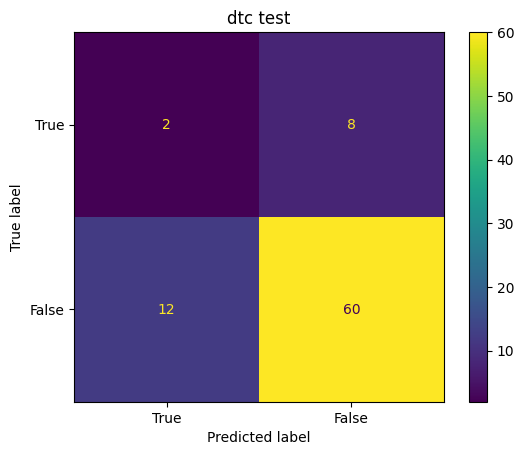

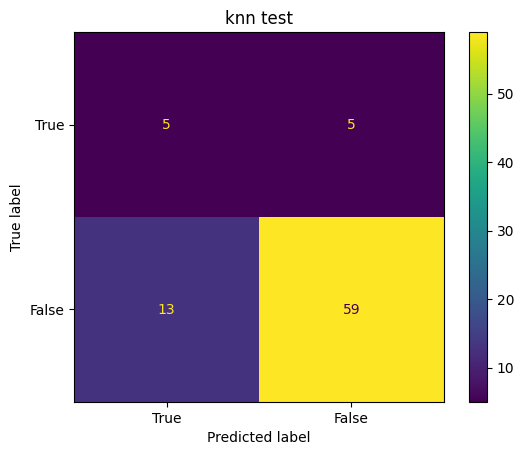

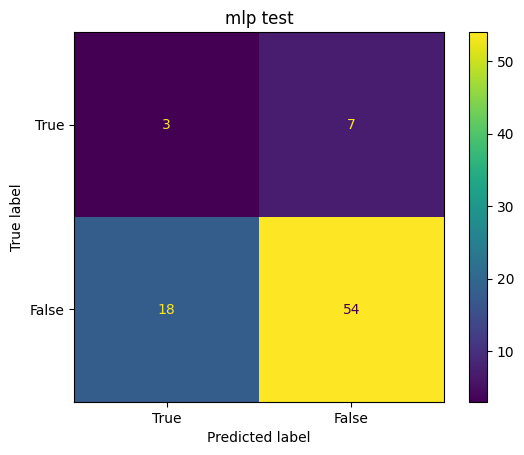

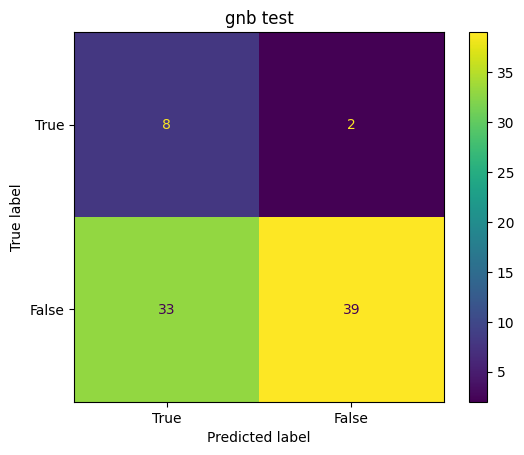

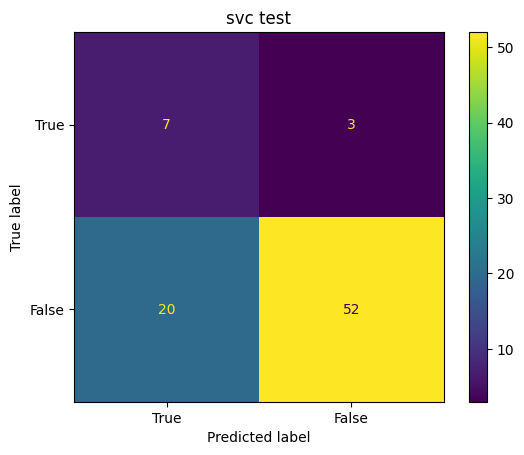

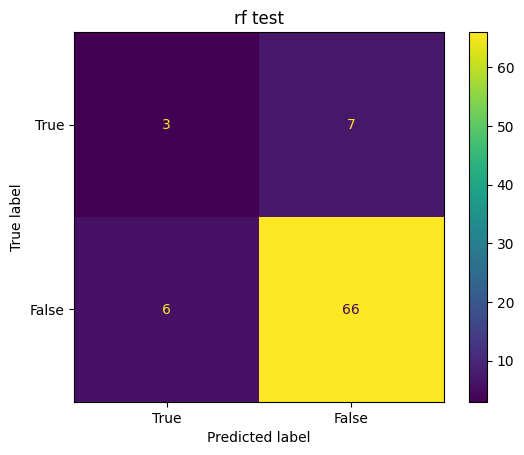

In [35]:
prob = 0.50

prefixes = ('test', 'train')
for prefix in prefixes[:1]:
    for name in results.keys():
        result = results[name]
        prefix = 'test'
        conf_matrix(result['y_'+prefix], np.where(result[prefix+'pred_prob'][:,-1] > prob, 1, -1), name, prefix)

### AUC

DTC test:	 0.5166666666666667
DTC train:	 1.0
KNN test:	 0.7069444444444445
KNN train:	 0.9586640211640212
MLP test:	 0.5159722222222223
MLP train:	 0.6370370370370371
GNB test:	 0.8125
GNB train:	 0.7207671957671957
SVC test:	 0.7847222222222221
SVC train:	 0.674074074074074
RF test:	 0.8541666666666666
RF train:	 1.0


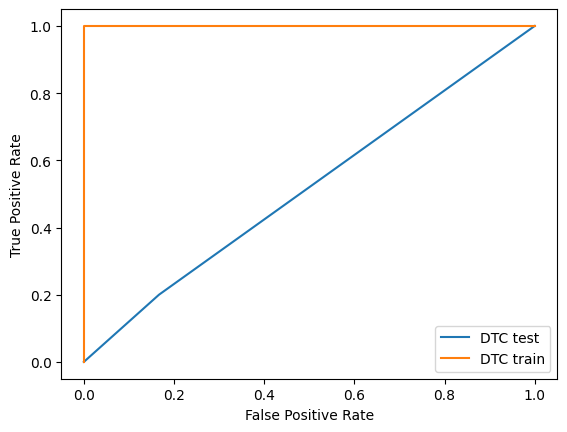

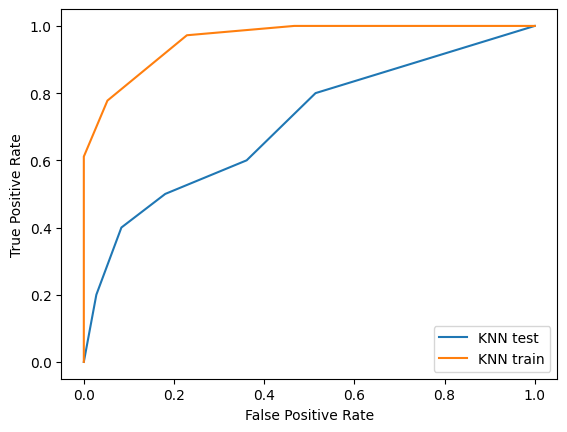

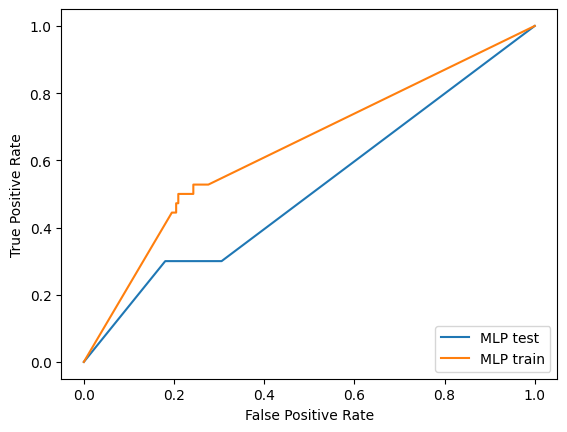

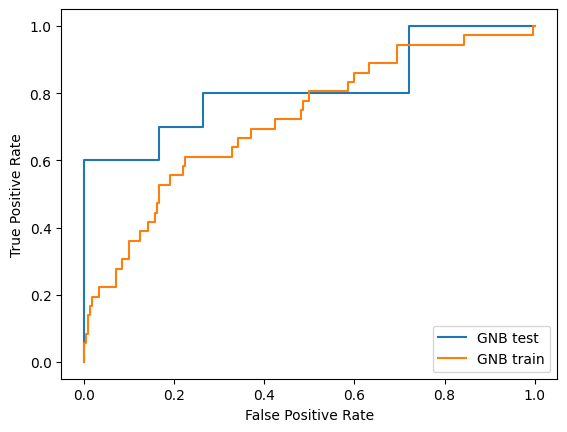

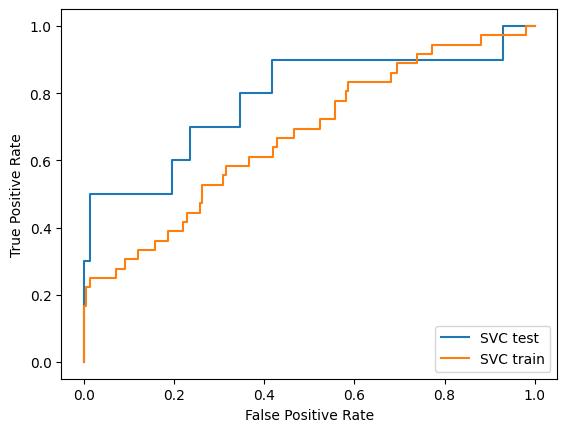

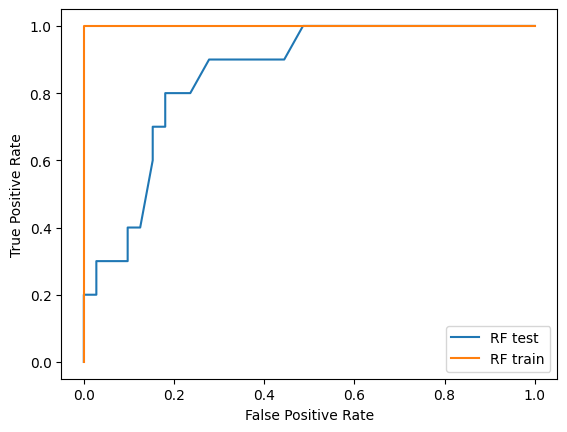

In [36]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

def roc_and_auc(name, isTrain=False):
    fig, ax = plt.subplots()
    for prefix in ('test', 'train'):
        result = results[name]
        fpr, tpr, thresholds = roc_curve(result['y_'+prefix], result[prefix+'pred_prob'][:,0], pos_label=result['model'].classes_[0])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax,name=(name.upper()+' '+prefix))
        print(name.upper(), prefix + ":\t", auc(fpr, tpr))

for name in results.keys():
    roc_and_auc(name)